In [157]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [158]:
def feature_selection(data, label, top_attribute):
    data = data.dropna()
    predictors = data.loc[:, data.columns != label]
    class_label = data.loc[:, data.columns == label]
    
    # apply SelectKBest class to extract top 10 best features
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    bestfeatures = SelectKBest(score_func=f_regression, k=5)
    fit = bestfeatures.fit(predictors, class_label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(predictors.columns)
    
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    # naming the dataframe columns
    featureScores.columns = ['Predictors','Score']  
    
    # print 10 best features
    ranked_features = featureScores.sort_values(by='Score',ascending=False)
    ranked_features = ranked_features.reset_index()
    ranked_features = ranked_features.drop(['index'], axis = 1)
    
    # creating columns names for the selected features
    data = data.reset_index()
    top_attributes_list = ['Date']
    top_attributes_list.extend(ranked_features['Predictors'].tolist()[:top_attribute])
    top_attributes_list.extend([label])
    
    # create dataframe of the selected features
    data = data[top_attributes_list]
    data = data.set_index('Date')
    return data

In [159]:
def calculate_rmse(data, algorithm):
    X = data.iloc[:,:-1].values
    y = data.iloc[:,-1:].values
    tscv = TimeSeriesSplit(n_splits=len(data)-1)
    
    rmses = []
    for train_index, test_index in tscv.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if algorithm == 'AdaBoost':
            from sklearn.tree import DecisionTreeRegressor
            from sklearn.ensemble import AdaBoostRegressor
            regr = AdaBoostRegressor(random_state=0, n_estimators=100)
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            
        elif algorithm == 'Random Forest':
            from sklearn.ensemble import RandomForestRegressor
            regr = RandomForestRegressor(max_depth=2, random_state=0)
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            
        elif algorithm == 'XGBoost':
            from xgboost import XGBRegressor
            regr = XGBRegressor(objective='reg:squarederror')
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            
        elif algorithm == 'Bagging':
            from sklearn.tree import DecisionTreeRegressor
            from sklearn.ensemble import BaggingRegressor
            regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
    
        from sklearn.metrics import mean_squared_error
        try:
            rmse = mean_squared_error(y_test, predict, squared=False)
        except:
            rmse = np.NaN
        rmses.append(rmse)
    
    rmses = [rmse for rmse in rmses if str(rmse) != 'nan']
    print('The', algorithm, 'RMSE for Expanding Windows is', sum(rmses)/len(rmses))

In [175]:
def predict_using_expanding_window(data, algorithm):
    X = data.iloc[:,:-1].values
    y = data.iloc[:,-1:].values
    tscv = TimeSeriesSplit(n_splits=len(data)-1)
    
    predictions = [np.NaN]
    for train_index, test_index in tscv.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if algorithm == 'AdaBoost':
            from sklearn.tree import DecisionTreeRegressor
            from sklearn.ensemble import AdaBoostRegressor
            regr = AdaBoostRegressor(random_state=0, n_estimators=100)
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            predictions.extend(predict)
            
        elif algorithm == 'Random Forest':
            from sklearn.ensemble import RandomForestRegressor
            regr = RandomForestRegressor(max_depth=2, random_state=0)
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            predictions.extend(predict)
            
        elif algorithm == 'XGBoost':
            from xgboost import XGBRegressor
            regr = XGBRegressor(objective='reg:squarederror')
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            predictions.extend(predict)
            
        elif algorithm == 'Bagging':
            from sklearn.tree import DecisionTreeRegressor
            from sklearn.ensemble import BaggingRegressor
            regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
            regr.fit(X_train, y_train)
            predict = regr.predict(X_test)
            predictions.extend(predict)
        
    data['Predictions'] = pd.DataFrame(predictions, index=data.index)
    return data.tail(5)

In [176]:
def plot_time_series(data, title):
    data = data.reset_index()
    plt.plot_date(data['Date'], data['PCI'], color = 'black', marker = 'o', label = 'actual', linestyle = '-')
    plt.plot_date(data['Date'], data['Predictions'], color = 'red', marker = 'o', label = 'predict', linestyle = '--')
    plt.legend()
    plt.grid()
    plt.xlabel('\nDate')
    plt.ylabel('RM (millions)\n')
    plt.title('Prediction of Real Private Consumption using ' + str(title))

In [183]:
adaboost_df      = pd.read_csv('AdaBoost Dataset.csv',parse_dates=[0])
xgboost_df       = pd.read_csv('XGBoost Dataset.csv',parse_dates=[0])
bagging_df       = pd.read_csv('Bagging Dataset.csv',parse_dates=[0])
random_forest_df = pd.read_csv('Random Forest Dataset.csv',parse_dates=[0])

adaboost_df      = adaboost_df.set_index('Date')
xgboost_df       = xgboost_df.set_index('Date')
bagging_df       = bagging_df.set_index('Date')
random_forest_df = random_forest_df.set_index('Date')

---------------------------------------------------------------------
Calculating RMSE
---------------------------------------------------------------------
The XGBoost RMSE for Expanding Windows is 6147.6078125
---------------------------------------------------------------------
Modelling and Predict Future Values
---------------------------------------------------------------------


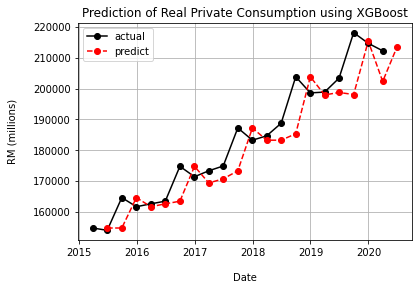

In [186]:
dataset = xgboost_df
title   = "XGBoost"
print('---------------------------------------------------------------------')
print('Calculating RMSE')
print('---------------------------------------------------------------------')
calculate_rmse(dataset, algorithm=title)
print('---------------------------------------------------------------------')
print('Modelling and Predict Future Values')
predict_using_expanding_window(dataset, algorithm=title)
print('---------------------------------------------------------------------')
plot_time_series(dataset,title=title)